In [1]:
import os, sys

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 40  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [3]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [4]:
# load in the data
t = 0
for line in open(r'spa.txt', encoding='utf-8'):
    # only keep a limited number of samples
    t += 1
    if t > NUM_SAMPLES:
        break

    # input and target are separated by tab
    if '\t' not in line:
        continue

    # split up the input and translation
    input_text, translation, *rest = line.rstrip().split('\t')

    # make the target input and output
    # recall we'll be using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [5]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [6]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

Found 2364 unique input tokens.


In [7]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [8]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 6294 unique output tokens.


In [9]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

In [10]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 14]
decoder_inputs[0]: [   2 1480    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 9)


In [12]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove6d/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding='utf-8' ) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [13]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [14]:
# create embedding layer
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_len_input)

In [15]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros( (len(input_texts), max_len_target,num_words_output), dtype='float32')

In [16]:
# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        if word != 0:
            decoder_targets_one_hot[i, t, word] = 1

In [17]:
print(decoder_targets_one_hot[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
print(decoder_targets_one_hot.shape)

(10000, 9, 6295)


In [19]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM( LATENT_DIM, return_state=True)
encoder_outputs, h, c = encoder(x)

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM( LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm( decoder_inputs_x, initial_state=encoder_states)

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 100)       236500      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 9, 100)       629500      input_2[0][0]                    
______________________________________________________________________________________________

In [20]:
import tensorflow.keras.backend as K

def custom_loss(y_true, y_pred):
    # both are of shape N x T x K
    mask = K.cast(y_true > 0, dtype='float32')
    out = mask * y_true * K.log(y_pred)
    return -K.sum(out) / K.sum(mask)

In [21]:
def acc(y_true, y_pred):
    # both are of shape N x T x K
    targ = K.argmax(y_true, axis=-1)
    pred = K.argmax(y_pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(targ, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct / n_total

In [22]:
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

In [23]:
r = model.fit( [encoder_inputs, decoder_inputs], decoder_targets_one_hot, 
              batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Epoch 1/40
125/125 [==============================] - 12s 60ms/step - loss: 5.9741 - acc: 0.2726 - val_loss: 5.5662 - val_acc: 0.2689
Epoch 2/40
125/125 [==============================] - 7s 54ms/step - loss: 4.9494 - acc: 0.2945 - val_loss: 5.3660 - val_acc: 0.2815
Epoch 3/40
125/125 [==============================] - 7s 55ms/step - loss: 4.5952 - acc: 0.3146 - val_loss: 5.1864 - val_acc: 0.3065
Epoch 4/40
125/125 [==============================] - 7s 55ms/step - loss: 4.2704 - acc: 0.3427 - val_loss: 5.0420 - val_acc: 0.3211
Epoch 5/40
125/125 [==============================] - 7s 55ms/step - loss: 3.9557 - acc: 0.3766 - val_loss: 4.9136 - val_acc: 0.3449
Epoch 6/40
125/125 [==============================] - 7s 55ms/step - loss: 3.6774 - acc: 0.4094 - val_loss: 4.8490 - val_acc: 0.3612
Epoch 7/40
125/125 [==============================] - 7s 55ms/step - loss: 3.4421 - acc: 0.4314 - val_loss: 4.7815 - val_acc: 0.3738
Epoch 8/40
125/125 [==============================] - 7s 54ms/step -

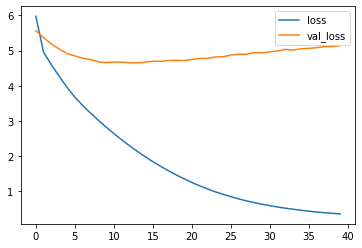

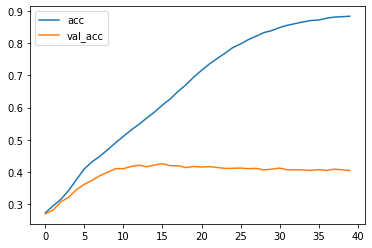

In [25]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('s2s.h5')

##### Make predictions #####
 As with the poetry example, we need to create another model that can take in the RNN state and previous word as input
 and accept a T=1 sequence. The encoder will be stand-alone From this we will get our initial decoder hidden state

In [26]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm( decoder_inputs_single_x, initial_state=decoder_states_inputs)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model( [decoder_inputs_single] + decoder_states_inputs,  [decoder_outputs] + decoder_states)

In [27]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [31]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # if we get this we break
    eos = word2idx_outputs['<eos>']

    # Create the translation
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value )

        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c]
        # states_value = [h] # gru

    return ' '.join(output_sentence)

In [32]:
while True:
    # Do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', input_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

-
Input: Are you 18?
Translation: ¿tienes dieciocho?
Continue? [Y/n]y
-
Input: Let me get it.
Translation: déjame cogerlo.
Continue? [Y/n]y
-
Input: I admit it.
Translation: lo admito.
Continue? [Y/n]n
